<img align="center" src="figures/course.png" width="800">

#                                    16720 (B) Neural Networks for Recognition - Assignment 3

     Instructor: Kris Kitani                       TAs: Qichen(Lead), Paritosh, Rawal, Yan, Zen, Wen-Hsuan

## Q7 PyTorch (40 points)

**Please include all the write up answers below to theory.ipynb. For the questions need code, you need to include the screenshot of code to theory.ipynb to get points.**

While you were able to derive manual back-propagation rules for sigmoid and fully-connected layers, wouldn't it be nice if someone did that for lots of useful primatives and made it fast and easy to use for general computation?  Meet [automatic differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation). Since we have high-dimensional inputs (images) and low-dimensional outputs (a scalar loss), it turns out **forward mode AD** is very efficient. Popular autodiff packages include [pytorch](https://pytorch.org/) (Facebook), [tensorflow](https://www.tensorflow.org/) (Google), [autograd](https://github.com/HIPS/autograd) (Boston-area academics). Autograd provides its own replacement for numpy operators and is a drop-in replacement for numpy, except you can ask for gradients now. The other two are able to act as shim layers for [cuDNN](https://developer.nvidia.com/cudnn), an implementation of auto-diff made by Nvidia for use on their GPUs. Since GPUs are able to perform large amounts of math much faster than CPUs, this makes the former two packages very popular for researchers who train large networks. Tensorflow asks you to build a computational graph using its API, and then is able to pass data through that graph. PyTorch builds a dynamic graph and allows you to mix autograd functions with normal python code much more smoothly, so it is currently more popular among CMU students. 

We will use [pytorch](https://pytorch.org/) as a framework. Many computer vision projects use neural networks as a basic building block, so familiarity with one of these frameworks is a good skill to develop. Here, we basically replicate and slightly expand our handwritten character recognition networks, but do it in PyTorch instead of doing it ourselves. Feel free to use any tutorial you like, but we like [the offical one](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) or [this tutorial](http://cs231n.stanford.edu/notebooks/pytorch_tutorial.ipynb) (in a jupyter notebook) or [these slides](http://cs231n.stanford.edu/slides/2018/cs231n_2018_lecture08.pdf (starting from number 35).

**For this section, you're free to implement these however you like. All of the tasks required here are fairly small and don't require a GPU if you use small networks. Including 7.2.**

### Q7.1 Train a neural network in PyTorch

#### Q7.1.1 (10 Points Code+WriteUp)
 
Re-write and re-train your fully-connected network on NIST36 in PyTorch. Plot training accuracy and loss over time.

<font color="red">**Please include the write up answer and the screenshot of code to theory.ipynb**</font>

In [15]:
import nbimporter
import numpy as np
import scipy.io
from torch import nn, optim
import torch.nn.functional as F
from q2 import *
import torch
import torchvision.datasets
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
max_iters = 50
batch_size = 30
learning_rate = 2.55e-2
hidden_size = 64

In [16]:
#Loading the dataset
train_data = scipy.io.loadmat('data/nist36_train.mat')
valid_data = scipy.io.loadmat('data/nist36_valid.mat')

train_x, train_y = train_data['train_data'], train_data['train_labels']
valid_x, valid_y = valid_data['valid_data'], valid_data['valid_labels']

#Converting to Tensor 
tensor_x = torch.Tensor(train_x).float() # transform to torch tensor
tensor_y = torch.Tensor(train_y)

val_x, val_y = torch.Tensor(valid_data['valid_data']).float(), torch.Tensor(valid_data['valid_labels'])

#Loading to dataloader
trainset_loader = DataLoader(TensorDataset(tensor_x, tensor_y), batch_size= batch_size, shuffle=True, num_workers=1)
validset_loader = DataLoader(TensorDataset(val_x, val_y), batch_size= batch_size, shuffle=True, num_workers=1)


#Creating a Class of the torch module:
D = train_x.shape[1]
C = train_y.shape[1]
#print(C)
tot = tensor_y.shape[1]
#print(tot)

class Net(nn.Module):

    def __init__(self, D, hidden_size, C ):
        super(Net, self).__init__()
        
        self.fc1 = nn.Linear(D, hidden_size) #Two layers input Dimension is number of datapoints i, middle layer 
        #is the hidden layer 
        self.fc2 = nn.Linear(hidden_size, C)#output layer is the number of classes 
      
    def forward(self, x):
        
        x = torch.sigmoid( self.fc1(x))
        # If the size is a square, you can specify with a single number
        x = self.fc2(x)
        return x

# use_cuda = torch.cuda.is_available()
#device = torch.device("cuda" if use_cuda else "cpu")
model = Net(D, hidden_size, C )

#Gradient Descent with momentum
optimizer = optim.SGD(model.parameters(), lr=learning_rate , momentum=0.9)

train_acclist =[]

train_losslist =[]


# with default settings, you should get loss < 150 and accuracy > 80%
for itr in range(max_iters):
    total_loss = 0
    
    total_acc =0
    for batch_idx, (data, target) in enumerate(trainset_loader):
        data, target = Variable(data), Variable(target)
        t_x, t_y =data, target
        
        #Cross entropy doesnt take hot vectors directly
        t_y = torch.max(t_y, 1)[1]
        
        #print(t_y.shape)
        #print(t_y)
        prediction = model(t_x)
    
        
        #F.nll_loss not working 
        #Calculating loss
        loss = F.cross_entropy(prediction, t_y)
        total_loss += loss.item() 
        
        
        _, preds = torch.max(prediction, dim=1)
        accuracy = torch.tensor(torch.sum(preds == t_y).item() / len(preds))
        total_acc += accuracy
        
        #backward
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    avg_acc = total_acc/(batch_idx+1)
    if itr % 2 == 0:
        
        print("itr: {:02d} \t loss: {:.2f} \t acc : {:.2f} \t avg_acc : {:.2f}".format(itr,total_loss,total_acc, avg_acc))
            
    
    model.eval()  # set evaluation mode
    valid_loss = 0
    valid_acc = 0
    with torch.no_grad():
        for v_idx, (data, target) in enumerate(validset_loader):
            
            v_x, v_y = data, target
            
            v_pred = model(v_x)
            
            v_y = torch.max(v_y, 1)[1]
            
            loss = F.cross_entropy(v_pred, v_y)
            
            valid_loss += loss
            # Vloss.append(valid_loss)
            
            _, vpreds = torch.max(v_pred, dim=1)
            accuracy = torch.tensor(torch.sum(vpreds == v_y).item() / len(vpreds))
        
            valid_acc += accuracy
            

    val_avg_acc= valid_acc/(v_idx+1)
   
    if itr % 2 == 0:
        print("\n Validation set: itr: {:02d} \t loss: {:.2f} \t avg_acc : {:.2f}".format(itr,valid_loss, val_avg_acc))   
       
    
    train_acclist.append(avg_acc)
    train_losslist.append(total_loss)
    
    

itr: 00 	 loss: 1144.31 	 acc : 63.43 	 avg_acc : 0.18

 Validation set: itr: 00 	 loss: 294.36 	 avg_acc : 0.36
itr: 02 	 loss: 515.66 	 acc : 220.80 	 avg_acc : 0.61

 Validation set: itr: 02 	 loss: 160.84 	 avg_acc : 0.63
itr: 04 	 loss: 410.06 	 acc : 245.20 	 avg_acc : 0.68

 Validation set: itr: 04 	 loss: 148.03 	 avg_acc : 0.65
itr: 06 	 loss: 357.45 	 acc : 258.80 	 avg_acc : 0.72

 Validation set: itr: 06 	 loss: 126.10 	 avg_acc : 0.69
itr: 08 	 loss: 317.54 	 acc : 269.87 	 avg_acc : 0.75

 Validation set: itr: 08 	 loss: 128.56 	 avg_acc : 0.69
itr: 10 	 loss: 295.05 	 acc : 276.13 	 avg_acc : 0.77

 Validation set: itr: 10 	 loss: 108.55 	 avg_acc : 0.74
itr: 12 	 loss: 270.55 	 acc : 282.27 	 avg_acc : 0.78

 Validation set: itr: 12 	 loss: 108.75 	 avg_acc : 0.74
itr: 14 	 loss: 249.28 	 acc : 289.33 	 avg_acc : 0.80

 Validation set: itr: 14 	 loss: 106.91 	 avg_acc : 0.74
itr: 16 	 loss: 228.91 	 acc : 294.13 	 avg_acc : 0.82

 Validation set: itr: 16 	 loss: 102.27 

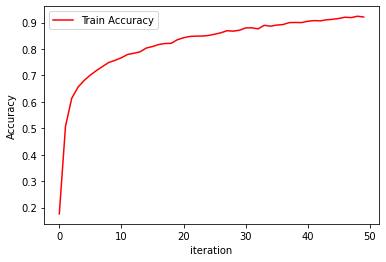

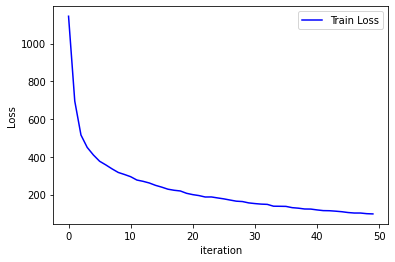

In [17]:
#PLotting the Graphs for accuracy and loss

a = np.arange(0, max_iters)
train_acclist =np.asarray(train_acclist)

train_losslist =np.asarray(train_losslist)



plt.figure(0)
plt.plot(a, train_acclist, 'r')
plt.legend(['Train Accuracy'])
plt.xlabel('iteration')
plt.ylabel('Accuracy')

plt.figure(1)
plt.plot(a, train_losslist, 'b')
plt.legend(['Train Loss', 'Validation Loss'])
plt.xlabel('iteration')
plt.ylabel('Loss')

plt.show()

#### Q7.1.2 (3 Points Code+WriteUp)
 
Train a convolutional neural network with PyTorch on MNIST. Plot training accuracy and loss over time.

<font color="red">**Please include the write up answer and the screenshot of code to theory.ipynb**</font>

In [18]:
import numpy as np
import scipy.io
import torch
import torchvision
from torch import nn, optim
import torch.nn.functional as F  # a lower level (compared to torch.nn) interface
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from time import time

# Use GPU if available, otherwise stick with cpu
use_cuda = torch.cuda.is_available()
torch.manual_seed(123)

device = torch.device("cuda" if use_cuda else "cpu")
print("device = {}".format(device))
print("Get dataset")

mnist_train = MNIST(root="data", train=True, download=True, transform=transforms.ToTensor())
trainset_loader = DataLoader(mnist_train, batch_size=20, shuffle=True, num_workers=1)

mnist_test = MNIST(root="data", train=False, download=True, transform=transforms.ToTensor())
testset_loader = DataLoader(mnist_test, batch_size=20, shuffle=True, num_workers=1)

print("dataset size train, test")
print(trainset_loader.dataset.data.shape)
print(testset_loader.dataset.data.shape)

max_iters = 5
train_accmnist =[]
train_lossmnist =[]

#Creating a CNN with 2 layers of crosscorelation (conv2D) and 2 linear connection
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.lay1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=3,              
                stride=1,                   
                padding=1,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.lay2 = nn.Sequential(         
            nn.Conv2d(16, 32, 3, 1, 1),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer, output 10 classes
        #input dimension from the convolution based on the formula (w-k+2p)/s +1
        self.fc1 = nn.Linear(32*7*7, 196)
        self.fc2 = nn.Linear(196, 10)
    
    def forward(self, x):
        x = self.lay1(x)
        x = self.lay2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        x = self.fc1(x)
        x= self.fc2(x)
        
        return x 

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001 , momentum=0.9)

for itr in range(max_iters):
    total_loss = 0
    
    total_acc =0
    for batch_idx, (data, target) in enumerate(trainset_loader):
        data, target = Variable(data), Variable(target)
        #print(batch_idx)
        t_x, t_y =data, target
       
        #Forward prop
        prediction = model(t_x)
            
        #F.nll_loss not working 
        #Calculating Loss and accuracy
        loss = F.cross_entropy(prediction, t_y)
        total_loss += loss.item() 
        
        
        _, preds = torch.max(prediction, dim=1)
        accuracy = torch.tensor(torch.sum(preds == t_y).item() / len(preds))
        total_acc += accuracy
        
        #backward
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    avg_acc = total_acc/(batch_idx+1)
    
        
    print("itr: {:02d} \t loss: {:.2f} \t acc : {:.2f} \t avg_acc : {:.2f}".format(itr,total_loss,total_acc, avg_acc))
    train_accmnist.append(avg_acc)
    train_lossmnist.append(total_loss)
    
    model.eval()  # set evaluation mode
    valid_loss = 0
    valid_acc = 0
    with torch.no_grad():
        for v_idx, (data, target) in enumerate(testset_loader):
            
            v_x, v_y = data, target
            
            v_pred = model(v_x)
                        
            loss = F.cross_entropy(v_pred, v_y)
            
            valid_loss += loss
                        
            _, vpreds = torch.max(v_pred, dim=1)
            accuracy = torch.tensor(torch.sum(vpreds == v_y).item() / len(vpreds))
        
            valid_acc += accuracy
           
    val_avg_acc= valid_acc/(v_idx+1)
   
    
    print("\n Validation set: itr: {:02d} \t loss: {:.2f} \t avg_acc : {:.2f}".format(itr,valid_loss, val_avg_acc))   


device = cpu
Get dataset
dataset size train, test
torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])
itr: 00 	 loss: 1511.57 	 acc : 2553.02 	 avg_acc : 0.85

 Validation set: itr: 00 	 loss: 81.04 	 avg_acc : 0.95
itr: 01 	 loss: 404.68 	 acc : 2878.22 	 avg_acc : 0.96

 Validation set: itr: 01 	 loss: 44.85 	 avg_acc : 0.97
itr: 02 	 loss: 282.28 	 acc : 2914.97 	 avg_acc : 0.97

 Validation set: itr: 02 	 loss: 35.55 	 avg_acc : 0.98
itr: 03 	 loss: 233.63 	 acc : 2928.62 	 avg_acc : 0.98

 Validation set: itr: 03 	 loss: 30.98 	 avg_acc : 0.98
itr: 04 	 loss: 201.84 	 acc : 2939.92 	 avg_acc : 0.98

 Validation set: itr: 04 	 loss: 27.97 	 avg_acc : 0.98


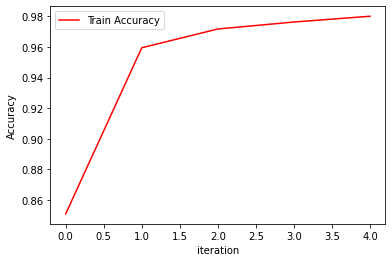

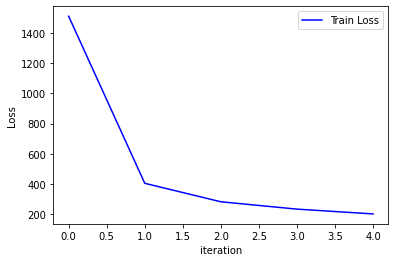

In [19]:
import matplotlib.pyplot as plt
a = np.arange(0, max_iters)
train_accmnist =np.asarray(train_accmnist)
train_lossmnist =np.asarray(train_lossmnist)

plt.figure(0)
plt.plot(a, train_accmnist, 'r')
plt.legend(['Train Accuracy'])
plt.xlabel('iteration')
plt.ylabel('Accuracy')

plt.figure(1)
plt.plot(a, train_lossmnist, 'b')
plt.legend(['Train Loss', 'Validation Loss'])
plt.xlabel('iteration')
plt.ylabel('Loss')

plt.show()

#### Q7.1.3 (2 Points Code+WriteUp)
 
Train a convolutional neural network with PyTorch on the included NIST36 dataset. Plot training accuracy and loss over time.

<font color="red">**Please include the write up answer and the screenshot of code to theory.ipynb**</font>

In [20]:
import numpy as np
import scipy.io
import torch
from torch import nn, optim
import torch.nn.functional as F  # a lower level (compared to torch.nn) interface
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from time import time
import matplotlib.pyplot as plt

# Use GPU if available, otherwise stick with cpu
#use_cuda = torch.cuda.is_available()
torch.manual_seed(123)
#device = torch.device("cuda" if use_cuda else "cpu")
print("device = {}".format(device))

print("Get dataset")
train_data = scipy.io.loadmat('data/nist36_train.mat')
valid_data = scipy.io.loadmat('data/nist36_valid.mat')

train_x, train_y = train_data['train_data'].astype(np.float32), train_data['train_labels']
valid_x, valid_y = valid_data['valid_data'].astype(np.float32), valid_data['valid_labels']

tensor_x = torch.Tensor(train_x).float() # transform to torch tensor
tensor_y = torch.Tensor(train_y).int()

val_x, val_y = torch.Tensor(valid_x).float(), torch.Tensor(valid_y).int()

trainset_loader = DataLoader(TensorDataset(tensor_x, tensor_y), batch_size= batch_size, shuffle=True, num_workers=1)
validset_loader = DataLoader(TensorDataset(val_x, val_y), batch_size= batch_size, shuffle=True, num_workers=1)

print("dataset size train, test")
print(train_x.shape)
print(train_y.shape)

# YOUR CODE HERE
#raise NotImplementedError()

max_iters = 10
train_accnist =[]
train_lossnist =[]

# Defining the CNN
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.lay1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=8,            
                kernel_size=3,              
                stride=1,                   
                padding=1,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.lay2 = nn.Sequential(         
            nn.Conv2d(8, 16, 3, 1, 1),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer, output  classes 36
        self.fc1 = nn.Linear(1024, 256)
        self.fc2 = nn.Linear(256, 36)
    def forward(self, x):
        #print(x.size(0),x.size(1),x.size(2),x.size(3))
        x = self.lay1(x)
        #print(x.size(0),x.size(1),x.size(2),x.size(3))
        x = self.lay2(x)
        # flatten the output of conv2 to (batch_size, 32 *16*8)
        #print(x.size(0),x.size(1),x.size(2),x.size(3))
        x = x.view(x.size(0),-1 )       
        #print(x.size(0),x.size(1))
        x = self.fc1(x)
        #print(x.size(0),x.size(1))
        x= self.fc2(x)
        
        return x 

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

for itr in range(max_iters):
    total_loss = 0
    
    total_acc =0
    for batch_idx, (data, target) in enumerate(trainset_loader):
        data, target = Variable(data), Variable(target)
        #print(batch_idx)
        t_x, t_y =data, target
        
        #Reshaping to meet the dimension critera of nist 
        t_x = t_x.reshape(batch_size,1,32,32)
        #print(t_x.shape)
        #print(t_y.shape)
        
        #Cross entropy doesnt take hot vectors directly
        t_y = torch.max(t_y, 1)[1]
        
        #print(t_x.shape)
        #print(t_y)
        prediction = model(t_x)
    
        
        #F.nll_loss not working 
        loss = F.cross_entropy(prediction, t_y)
        total_loss += loss.item() 
        
        
        _, preds = torch.max(prediction, dim=1)
        accuracy = torch.tensor(torch.sum(preds == t_y).item() / len(preds))
        total_acc += accuracy
        
        #backward
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    avg_acc = total_acc/(batch_idx+1)
    
        
    print("itr: {:02d} \t loss: {:.2f} \t acc : {:.2f} \t avg_acc : {:.2f}".format(itr,total_loss,total_acc, avg_acc))
    train_accnist.append(avg_acc)
    train_lossnist.append(total_loss)
    
model.eval()  # set evaluation mode
valid_loss = 0
valid_acc = 0
with torch.no_grad():
    for v_idx, (data, target) in enumerate(validset_loader):
        v_x, v_y = data, target
        v_x = v_x.reshape(batch_size,1,32,32)
        v_pred = model(v_x)

        v_y = torch.max(v_y, 1)[1]

        loss = F.cross_entropy(v_pred, v_y)

        valid_loss += loss

        _, vpreds = torch.max(v_pred, dim=1)
        accuracy = torch.tensor(torch.sum(vpreds == v_y).item() / len(vpreds))

        valid_acc += accuracy
        
val_avg_acc= valid_acc/(v_idx+1)


print("\n Validation set: itr: {:02d} \t loss: {:.2f} \t avg_acc : {:.2f}".format(itr,valid_loss, val_avg_acc))   

device = cpu
Get dataset
dataset size train, test
(10800, 1024)
(10800, 36)
itr: 00 	 loss: 1289.08 	 acc : 12.57 	 avg_acc : 0.03
itr: 01 	 loss: 1279.32 	 acc : 35.93 	 avg_acc : 0.10
itr: 02 	 loss: 1204.66 	 acc : 100.07 	 avg_acc : 0.28
itr: 03 	 loss: 707.36 	 acc : 183.00 	 avg_acc : 0.51
itr: 04 	 loss: 418.51 	 acc : 240.90 	 avg_acc : 0.67
itr: 05 	 loss: 344.35 	 acc : 261.67 	 avg_acc : 0.73
itr: 06 	 loss: 298.77 	 acc : 274.53 	 avg_acc : 0.76
itr: 07 	 loss: 258.97 	 acc : 285.83 	 avg_acc : 0.79
itr: 08 	 loss: 226.53 	 acc : 294.63 	 avg_acc : 0.82
itr: 09 	 loss: 198.86 	 acc : 301.43 	 avg_acc : 0.84

 Validation set: itr: 09 	 loss: 74.62 	 avg_acc : 0.81


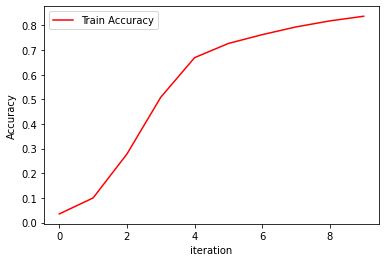

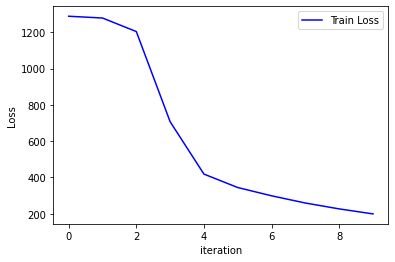

In [21]:
a = np.arange(0, max_iters)
train_accnist =np.asarray(train_accnist)

train_lossnist =np.asarray(train_lossnist)



plt.figure(0)
plt.plot(a, train_accnist, 'r')
plt.legend(['Train Accuracy'])
plt.xlabel('iteration')
plt.ylabel('Accuracy')

plt.figure(1)
plt.plot(a, train_lossnist, 'b')
plt.legend(['Train Loss', 'Validation Loss'])
plt.xlabel('iteration')
plt.ylabel('Loss')

plt.show()

#### Q7.1.4 (15 Points Code+WriteUp)
 
Train a convolutional neural network with PyTorch on the EMNIST Balanced dataset  (available in *torchvision.datasets*, use *balanced* split) and evaluate it on the findLetters bounded boxes from the images folder. Find the accuracy on these bounded boxes.

<font color="red">**Please include the write up answer and the screenshot of code to theory.ipynb**</font>

In [22]:
import numpy as np
import scipy.io
import torch
from torch import nn, optim
import torchvision
import torch.nn.functional as F  # a lower level (compared to torch.nn) interface
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import EMNIST
import torchvision.transforms as transforms
from time import time
from torch.autograd import Variable
# Use GPU if available, otherwise stick with cpu
use_cuda = torch.cuda.is_available()
torch.manual_seed(123)
device = torch.device("cuda" if use_cuda else "cpu")
print("device = {}".format(device))

print("Get dataset")

EMNIST.url = 'http://www.itl.nist.gov/iaui/vip/cs_links/EMNIST/gzip.zip'
# Reference for transform function
# https://stackoverflow.com/a/54513835
transform=torchvision.transforms.Compose([
    lambda img: torchvision.transforms.functional.rotate(img, -90),
    lambda img: torchvision.transforms.functional.hflip(img),
    torchvision.transforms.ToTensor()
])


train_accemnist =[]
train_lossemnist =[]

emnist_train = EMNIST(root="data", split='balanced', train=True, download=True, transform=transform)
emnist_test = EMNIST(root="data", split='balanced', train=False, download=True, transform=transform)


trainset_loader = DataLoader(emnist_train, batch_size=20, shuffle=True, num_workers=0)


testset_loader = DataLoader(emnist_test, batch_size=20, shuffle=True, num_workers=0)

# Ref: https://github.com/gaurav0651/emnist/blob/master/train_emnist.ipynb
label_map = ['0','1','2','3','4','5','6','7','8','9',
       'A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z',
       'a','b','d','e','f','g','h','n','q','r','t']

print(trainset_loader.dataset.data.shape)
print(testset_loader.dataset.data.shape)


class CNNet(nn.Module):
    def __init__(self):
        super(CNNet, self).__init__()
        self.lay1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=3,              
                stride=1,                   
                padding=1,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.lay2 = nn.Sequential(         
            nn.Conv2d(16, 32, 3, 1, 1),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer
        #Input dimensions 28*28 convolved into dimension 32*x*x
        self.fc1 = nn.Linear(32*7*7, 1024)
        self.fc2 = nn.Linear(1024, 47)
        #Output layer is 47 
     
    
    def forward(self, x):
        x = self.lay1(x)
        x = self.lay2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        x = self.fc1(x)
        x= self.fc2(x)
        #x = self.fc3(x)
        return x 

model3 = CNNet().to(device)
optimizer = optim.SGD(model3.parameters(), lr=0.0021 , momentum=0.9)
max_iters = 5
for itr in range(max_iters):
    
    model3.train()
    total_loss = 0
    total_acc =0
    for batch_idx, (data, target) in enumerate(trainset_loader):
   
        data, target = Variable(data), Variable(target)
        #print(batch_idx)
        t_x, t_y =data, target
        
        #Forward prop
        prediction = model3(t_x)
    
        
        #F.nll_loss not working
        #Loss and accuracy
        loss = F.cross_entropy(prediction, t_y)
        total_loss += loss.item() 
        
        
        _, preds = torch.max(prediction, dim=1)
        accuracy = torch.tensor(torch.sum(preds == t_y).item() / len(preds))
        total_acc += accuracy
        
        #backward
        loss.backward()
        #Updating 
        optimizer.step()
        optimizer.zero_grad()
    avg_acc = total_acc/(batch_idx+1)
    
        
    print("itr: {:02d} \t loss: {:.2f} \t acc : {:.2f} \t avg_acc : {:.2f}".format(itr,total_loss,total_acc, avg_acc))
    train_accemnist.append(avg_acc)
    train_lossemnist.append(total_loss)
    
model3.eval()  # set evaluation mode
valid_loss = 0
valid_acc = 0
with torch.no_grad():
    for v_idx, (data, target) in enumerate(testset_loader):

        v_x, v_y = data, target
        
        v_pred = model3(v_x)

        

        loss = F.cross_entropy(v_pred, v_y)

        valid_loss += loss
        # Vloss.append(valid_loss)



        _, vpreds = torch.max(v_pred, dim=1)
        accuracy = torch.tensor(torch.sum(vpreds == v_y).item() / len(vpreds))

        valid_acc += accuracy
        # Vaccuracies.append(

#valid_loss /= len(validset_loader.dataset)
val_avg_acc= valid_acc/(v_idx+1)


print("\n Validation set: itr: {:02d} \t loss: {:.2f} \t avg_acc : {:.2f}".format(itr,valid_loss, val_avg_acc))   


# YOUR CODE HERE
#raise NotImplementedError()

device = cpu
Get dataset
torch.Size([112800, 28, 28])
torch.Size([18800, 28, 28])
itr: 00 	 loss: 5319.65 	 acc : 4058.02 	 avg_acc : 0.72
itr: 01 	 loss: 2798.53 	 acc : 4714.26 	 avg_acc : 0.84
itr: 02 	 loss: 2480.34 	 acc : 4800.60 	 avg_acc : 0.85
itr: 03 	 loss: 2295.91 	 acc : 4853.75 	 avg_acc : 0.86
itr: 04 	 loss: 2161.51 	 acc : 4895.84 	 avg_acc : 0.87

 Validation set: itr: 04 	 loss: 404.47 	 avg_acc : 0.86


In [28]:
#Processing the previously appended bounding box images accorind the dataset in the EMNIST
import skimage
import pickle
def process(img):
    process=[]
    for im in img:
        crop_size = skimage.transform.resize(im,(28,28), anti_aliasing=True)
        crop_size = 1 -crop_size
        crop_size = crop_size.T
        #crop_size = crop_size*255
        process.append(crop_size)
    return process

In [30]:
import numpy as np
import skimage
import skimage.measure
import skimage.color as sc
import skimage.restoration as sr
import skimage.io
import skimage.filters as sf
import skimage.morphology
from skimage.morphology import closing, square
import skimage.segmentation
img1 = pickle.load(open('q4img1.pickle','rb'))
img2 = pickle.load(open('q4img2.pickle','rb'))
img3 = pickle.load(open('q4img3.pickle','rb'))
img4 = pickle.load(open('q4img4.pickle','rb'))
# print(np.asarray(img1).shape)
# print(np.asarray(img2).shape)
# print(np.asarray(img3).shape)
# print(np.asarray(img4).shape)

process1 = process(img1)
process2 = process(img2)
# print(np.asarray(process2).shape)
process3 = process(img3)
#print(np.asarray(process3).shape)
process4 = process(img4)
#print(np.asarray(process4).shape)

In [31]:
#Funtion to run the CNN and classify the processed images
def ans(process):
    
    st = ' '
    npimg =torch.Tensor(np.asarray(process).reshape((-1,1,28,28))).float()
    #Reshaped to required dimensions
    v_pred = model3(npimg)
    idx = torch.max(v_pred, 1)[1]
    idx = idx.int()
   
    id = (idx.numpy()).reshape((-1,1))

    st = ''
    for i in range(id.shape[0]):
        st += label_map[id[i,0]] + ' '
    return st

In [32]:
import pickle
import string
import numpy as np

Ans1 = 'T O D O L I S T 1 M A K E A T O D O L I S T 1 C H E C K O F F T H E F I R S T T H I N G O N T O D O L I S T 3 R E A L I Z E Y O U H A V E A L R E A D Y C O M P L E T E D 2 T H I N G S 4 R E W A R D Y O U R S E L F W I T H A N A P'
Ans2 = 'A B C D E F G H I J K L M N O P Q R S T U V W X Y Z 1 2 3 4 5 6 7 8 9 0'
Ans3 = 'H A I K U S A R E E A S Y B U T S O M E T I M E S T H E Y D O N T M A K E S E N S E R E F R I G E R A T O R'
Ans4 = 'D E E P L E A R N I N G D E E P E R L E A R N I N G D E E P E S T L E A R N I N G'

st1 = ans(process1)
st2 = ans(process2)
st3 = ans(process3)
st4 = ans(process4)
print('\nCorrect Ans1  :', Ans1)
print('Obtained Ans1: ', st1)
print('\nCorrect Ans2  :', Ans2)
print('Obtained Ans2: ', st2)

print('\nCorrect Ans3  :', Ans3)
print('Obtained Ans3: ', st3)

print('\nCorrect Ans4  :', Ans4)
print('Obtained Ans4: ', st4)



Correct Ans1  : T O D O L I S T 1 M A K E A T O D O L I S T 1 C H E C K O F F T H E F I R S T T H I N G O N T O D O L I S T 3 R E A L I Z E Y O U H A V E A L R E A D Y C O M P L E T E D 2 T H I N G S 4 R E W A R D Y O U R S E L F W I T H A N A P
Obtained Ans1:  T 0 D 0 L I S T I M A K E A T D D 0 L I S T 2 C H E C K 0 F F T T H E F I R S T T H I N G Q N 0 D 0 L I S T 3 R F A L I Z E Y 0 U T H H I A N V E G A L R E A D X C 0 M P L E T E D 2 S 4 R E W A R D V 0 U R S E L F W I T H A N A P 

Correct Ans2  : A B C D E F G H I J K L M N O P Q R S T U V W X Y Z 1 2 3 4 5 6 7 8 9 0
Obtained Ans2:  A B C D E F G H I J K L M N 0 P Q R S T U V W X Y Z I 2 3 4 S 6 7 8 9 Q 

Correct Ans3  : H A I K U S A R E E A S Y B U T S O M E T I M E S T H E Y D O N T M A K E S E N S E R E F R I G E R A T O R
Obtained Ans3:  H A I K U S A R E E A S Y B U T S Q M E F I M E S T H E Y D D W T M A K G S E N S E R E F R I G E R A F 0 R 

Correct Ans4  : D E E P L E A R N I N G D E E P E R L E A R N I N G D E E P E

### Q7.2 Fine Tuning

#### Q7.2.1 (10 Points Code+WriteUp)
 
Fine-tune a single layer classifier using pytorch on the [flowers 17](http://www.robots.ox.ac.uk/~vgg/data/flowers/17/index.html) (or [flowers 102](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html)!) dataset using [squeezenet1\_1](https://pytorch.org/docs/stable/torchvision/models.html), as well as an architecture you've designed yourself (*3 conv layers, followed 2 fc layers, it's standard [slide 6](http://cs231n.stanford.edu/slides/2018/cs231n_2018_lecture09.pdf)*) and trained from scratch. How do they compare? 
    
We include a script in `scripts/` to fetch the flowers dataset and extract it in a way that [PyTorch ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) can consume it, see [an example](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#afterword-torchvision), from **data/oxford-flowers17**. You should look at how SqueezeNet is [defined](https://github.com/pytorch/vision/blob/master/torchvision/models/squeezenet.py), and just replace the classifier layer. There exists a pretty good example for [fine-tuning](https://gist.github.com/jcjohnson/6e41e8512c17eae5da50aebef3378a4c) in PyTorch.

<font color="red">**Please include the write up answer and the screenshot of code to theory.ipynb**</font>

In [1]:
import numpy as np
import scipy.io
import torch
from torch import nn, optim
import torchvision
import torch.nn.functional as F  # a lower level (compared to torch.nn) interface
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import EMNIST
import torchvision.transforms as transforms
import torch
from torchvision import transforms, datasets

root ='scripts/'
data_transform = transforms.Compose([
        transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
hymenoptera_dataset = datasets.ImageFolder(root='hymenoptera_data/train',
                                           transform=data_transform)
dataset_loader = torch.utils.data.DataLoader(hymenoptera_dataset,
                                             batch_size=4, shuffle=True,
                                             num_workers=4)

train_accemnist =[]
train_lossemnist =[]

flower_train = EMNIST(root="data", split='balanced', train=True, download=True, transform=transform)
flower_test = EMNIST(root="data", split='balanced', train=False, download=True, transform=transform)

counter = 0
print(traindirs)
# Code for fine-tune squeezenet1_1
# YOUR CODE HERE
#raise NotImplementedError()

C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torchvision\transforms\transforms.py:935: UserWarning: The use of the transforms.RandomSizedCrop transform is deprecated, please use transforms.RandomResizedCrop instead.
  warnings.warn("The use of the transforms.RandomSizedCrop transform is deprecated, " +


FileNotFoundError: Couldn't find any class folder in scripts/.

In [ ]:
# Code for fine-tune the network you designed
# YOUR CODE HERE
#raise NotImplementedError()